## Visualizing results 6th Edition-  SpaCy Geottaging + Edinburgh Georesolution

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.

We have used the **Sixth Edition of the Encyclopaedia Britannica**. 
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_6_edition.txt nls defoe.nls.queries.georesolution_pages queries/lang_model.yml -r georesolution_en_core_web_lg_EB_six_edition' -n 16`


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`


### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [6]:
def plot_bar_places(df_group_places):
    # this is for plotting purpose
    index = np.arange(len(df_group_places['place_label']))
    plt.bar(index, df_group_places['count'], color='green')
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, df_group_places['place_label'], rotation=40, fontsize=8)
    plt.title('15 Places most mentioned using SpaCy and the Georesolver')

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from the directory "144133901",  which corresponds to the book "Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* (GPE and LOC) and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata


As a result we get a file per gazetter|book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver 
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en_core_web_lg)
    * year: Publication year 


In [7]:
results=read_query_results('georesolution_en_core_web_lg_EB_six_edition')

In [8]:
df_total= geresolution_dataframe(results)

In [9]:
df_total[["Place"]].count()

Place    144944
dtype: int64

In [10]:
df_total["Place"]= df_total["Place"].str.capitalize()

In [11]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
+,1,1,1
".874,874,874",1,1,1
1,1,1,1
1 america,1,1,1
1 britain,1,1,1
1 city,1,1,1
"1,0279",1,1,1
1104,1,1,1
1105,1,1,1


In [12]:
#df_total.groupby("Page").count()

In [13]:
#df_total.groupby(["Latitude", "Longitude"]).count()

In [14]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   

df_max_geolocations = df_filter.drop(0)

df_max_geolocations.head(15)


,Latitude,Longitude,count
4515,34.6120507,-82.765139,2016
10968,43.2256251,-75.48878740000001,1918
6266,38.3242916,-76.5168989,1679
16492,54,-4,1582
10217,42.4514848,-71.0864414,1126
14698,50.6391735835358,3.07591438293457,1092
6585,38.7937266,-77.8577722,1039
5245,36.2436749,-85.243301,1011
10512,42.7578673,-71.2422828,1003
4434,34.350601,-85.15801399999999,987


In [15]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=['Earth', 'The moon', 'Meridian', 'Jupiter', 'Venus', 'Kingdom']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)
    

0 2016 France
1 1918 Rome
4 1126 England
5 1092 Europe
6 1039 England
7 1011 France
8 1003 England
9 987 Rome
10 972 Paris
11 928 Europe
12 895 France
13 862 Holland
14 844 Scotland
15 823 Asia
16 799 Britain
17 787 Italy
18 777 England
19 756 Edinburgh
21 697 Scotland
22 621 Scotland
23 588 London
24 573 England
26 517 America
27 489 Venice
28 487 Rome
29 463 Africa


In [16]:
#Visualizing the 15 places in a Bar plot
df_places = {'place_label':place_label,'place_freq':place_freq}
df_places_freq = pd.DataFrame(df_places)
df_group_places = df_places_freq.groupby(['place_label'])['place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   


df_group_places

,place_label,count
5,England,4518
7,France,3922
12,Rome,3392
13,Scotland,2162
6,Europe,2020
11,Paris,972
8,Holland,862
2,Asia,823
3,Britain,799
9,Italy,787


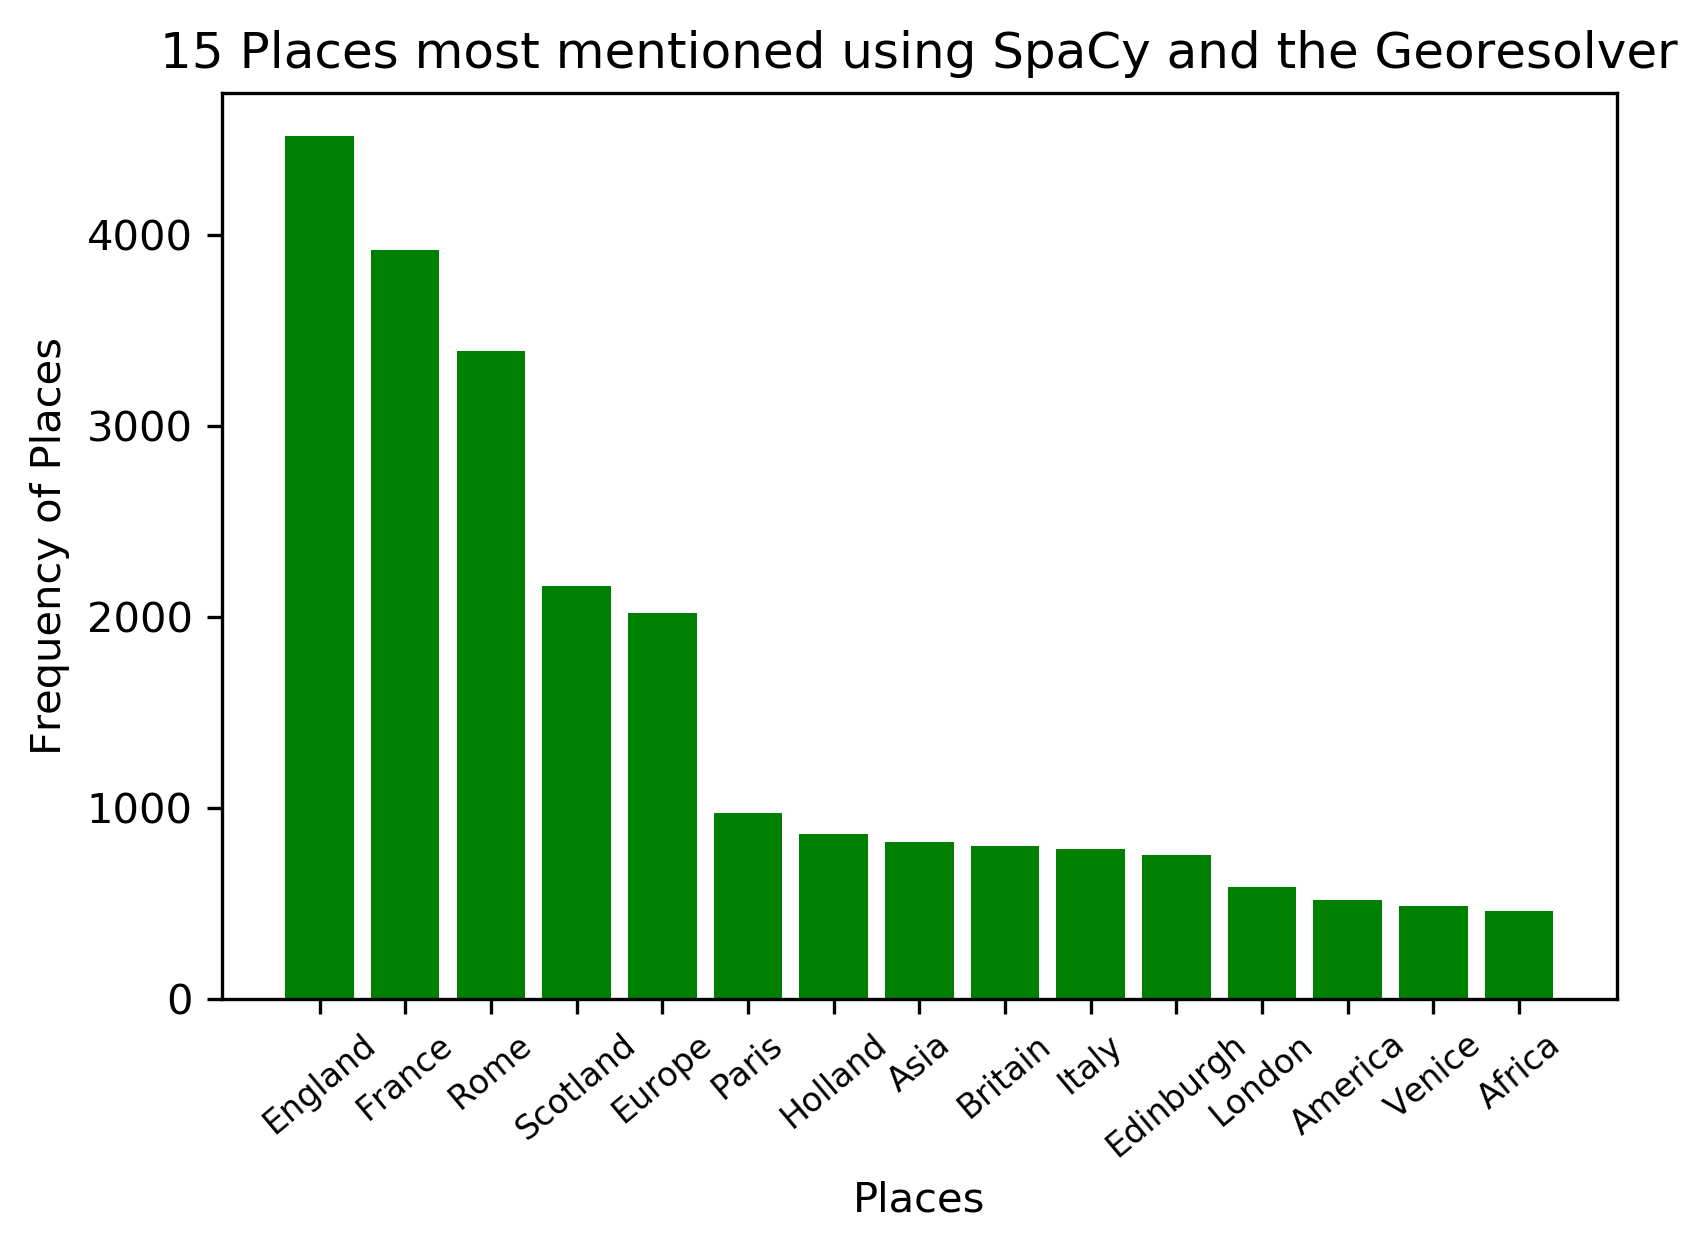

In [17]:
mpl.rcParams['figure.dpi']=300
plot_bar_places(df_group_places)